In [ ]:
# uncomment this cell if your data is the single .tar.gz
# import tarfile
# import glob
# import os

# base_dir = "/Users/alahi.irfan/Desktop/Local_workspace/Data/Bastidas-Ponce_Development_2019/GSE132188_RAW"

# os.chdir(base_dir)

# for f in glob.glob("*.tar.gz"):
#     folder = f[:-7]  # remove ".tar.gz"
#     folder_path = os.path.join(base_dir, folder)

#     os.makedirs(folder_path, exist_ok=True)

#     print(f"Extracting {f} → {folder_path}")

#     # Extract
#     with tarfile.open(f, "r:gz") as tar:
#         tar.extractall(path=folder_path)

#     # Delete only AFTER successful extraction
#     os.remove(f)
#     print(f"Deleted original: {f}")

# print("✔️ All done!")


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import scanpy as sc
sys.path.append(os.path.abspath("..")) 

In [ ]:
from scrna_pipeline import standard_scrna_pipeline

In [ ]:
from scrna_pipeline import h5ad_builders


parent_dir = "/Users/alahi.irfan/Desktop/Local_workspace/Data/Bastidas-Ponce_Development_2019/GSE132188_RAW"

adata_raw = h5ad_builders.tenx_folders_to_h5ad(
    parent_dir=parent_dir,
    inner_dir="mm10",                     # for this dataset
    var_names="gene_symbols",            # or "gene_ids"
    output_h5ad=parent_dir+'_combined.h5ad'
)



In [ ]:
print(adata_raw)
print(adata_raw.var_names[:5])
print(adata_raw.obs_names[:5])

In [39]:
# Choose the column in adata.obs that encodes batch / sample.
# If you have no batches, you can set batch_key=None and batch_method="none".
batch_key = "sample"   # change if your column is named differently

# Run the standard pipeline:
# - QC + filters + Scrublet
# - HVGs (Seurat v3 on counts by default)
# - normalize/log + scale + PCA
# - Harmony batch correction
# - neighbors + Leiden + UMAP
adata_proc = standard_scrna_pipeline(
    adata_raw,
    batch_key=batch_key,

    # batch correction method
    batch_method='none', #"harmony",

    # HVG selection
    hvg_flavor= "seurat", #"seurat_v3",
    n_top_genes=2000,

    # clustering
    clustering_method="leiden",

    # 👇 All preprocessing options go here
    preprocess_kwargs={
        "use_ribo_filter": False,
        "use_mito_filter": False,
        "run_scrublet": True

    },
)


print(adata_proc)



[ scrna-pipeline ] Running standard scRNA-seq pipeline
  • Input AnnData shape: 37977 cells × 19885 genes
  • Batch key:         'sample'
  • Batch method:      'none'
  • HVG flavor:        'seurat'
  • n_top_genes:       2000
  • n_pcs:             50
  • Clustering:        'leiden'
  • Cluster resol.:    0.6
  • Preprocess kwargs: {'run_scrublet': True, 'use_mito_filter': False, 'use_ribo_filter': False}
  • Batch kwargs:      {}
  • Cluster kwargs:    {}

Running Scrublet for doublet detection...
Removed 979 predicted doublets
After doublet removal: (36987, 19885)


/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


[ scrna-pipeline ] Step 1 complete: preprocess_to_pca
  • PCA stored in .obsm['X_pca']
  • Genes after HVG selection: 2000
  • Cells after QC / Scrublet: 36987

[ scrna-pipeline ] Step 2: no batch correction (using 'X_pca').

[ scrna-pipeline ] Step 3 complete: clustering + UMAP
  • Cluster labels in .obs['leiden']
  • UMAP stored in .obsm['X_umap']
  • Final AnnData shape: 36987 cells × 2000 genes

AnnData object with n_obs × n_vars = 36987 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', '

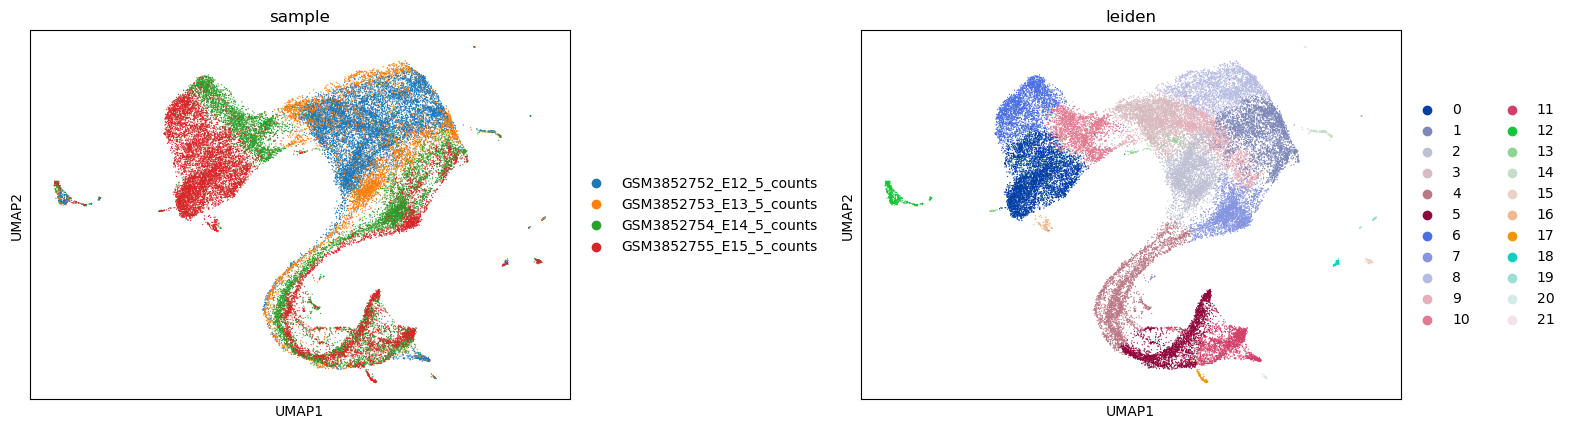

In [40]:
# Quick UMAP overview:
# - color by batch (e.g. "sample")
# - color by cluster ("louvain")
umap_colors = []

if "sample" in adata_proc.obs.columns:
    umap_colors.append("sample")

if "condition" in adata_proc.obs.columns:   # only if present in your data
    umap_colors.append("condition")

if "louvain" in adata_proc.obs.columns:
    umap_colors.append("louvain")

if "leiden" in adata_proc.obs.columns:
    umap_colors.append("leiden")

sc.pl.umap(
    adata_proc,
    color=umap_colors,
    wspace=0.4,
)

In [47]:
from scrna_pipeline.annotation import score_markers_and_suggest_labels


#mouse major cell types
# marker_dict = {

#     # ————— 1. Epithelial —————
#     "Epithelial": [
#         "Epcam", "Krt8", "Krt18"
#     ],

#     # ————— 2. Endothelial —————
#     "Endothelial": [
#         "Pecam1", "Kdr", "Esam"
#     ],

#     # ————— 3. Fibroblast / Stromal —————
#     "Fibroblast": [
#         "Col1a1", "Col1a2", "Dcn"
#     ],

#     # ————— 4. Smooth Muscle / Pericyte —————
#     "Smooth_Muscle": [
#         "Acta2", "Tagln", "Myh11"
#     ],

#     # ————— 5. Lymphoid Immune (T/B/NK lumped for coarse level) —————
#     "Lymphoid": [
#         "Cd3e", "Cd3d", "Cd3g"
#     ],

#     # ————— 6. Myeloid Immune (Mono/Macro/DC lumped) —————
#     "Myeloid": [
#         "Lyz2", "Lyz1", "Itgam"
#     ],

#     # ————— 7. Neural —————
#     "Neural": [
#         "Rbfox3", "Snap25", "Syt1"
#     ],

#     # ————— 8. Endocrine —————
#     "Endocrine": [
#         "Chga", "Chgb", "Scg2"
#     ],
# }


# marker_dict = {
#     # ——————————— Early progenitors ———————————
#     "MPCs": [  # multipotent pancreatic progenitors
#         "Pdx1", "Ptf1a", "Sox9", "Hnf1b", "Hnf6", "Nkx6-1", "Foxa2"
#     ],

#     "Tip_progenitors": [
#         "Ptf1a", "Gata4", "Gata6", "Rbpjl",
#         "Cpa1", "Prss1", "Ctrb1", "Cela1"   # early acinar enzymes
#     ],

#     "Trunk_progenitors": [
#         "Sox9", "Hnf1b", "Hnf6", "Krt19",
#         "Nkx6-1", "Muc1"
#     ],

#     # ——————————— Endocrine trajectory ———————————
#     "Ngn3_low_progenitors": [
#         "Neurog3",          # Ngn3 (low level)
#         "Pdx1", "Sox9", "Hnf6", "Foxa2",
#         "Nkx2-2"            # early endocrine bias
#     ],

#     "Ngn3_high_precursors": [
#         "Neurog3",          # high
#         "Neurod1", "Insm1", "Rfx6",
#         "Chga"              # chromogranin A (pro-endocrine)
#         # still little / no Ins1/2, Gcg, Sst at this stage
#     ],

#     "Fev_high_early_endocrine": [
#         "Fev", "Tph1", "Lmx1a", "Mafb",   # serotonin / early endocrine TFs
#         "Chga", "Neurod1", "Insm1"
#     ],

#     # ——————————— Mature differentiated lineages ———————————
#     "Acinar_cells": [
#         "Ptf1a", "Rbpjl",
#         "Cpa1", "Cpa2", "Cela1", "Prss1", "Ctrb1", "Sycn"
#     ],

#     "Ductal_cells": [
#         "Sox9", "Krt19", "Krt7", "Krt8", "Krt18",
#         "Muc1", "Muc20", "Hnf1b", "Krt17"
#     ],

#     # If you want all endocrine lumped together:
#     "Endocrine_cells_all": [
#         "Chga", "Chgb",
#         "Ins1", "Ins2", "Gcg", "Sst", "Ppy", "Ghrl",
#         "Pdx1", "Isl1", "Nkx2-2", "Nkx6-1", "MafA", "Mafb", "Pax6"
#     ],

#     # Or split by hormone type (optional, but often useful)
#     "Alpha_cells": [
#         "Gcg", "Mafb", "Arx", "Tcf7l2"
#     ],
#     "Beta_cells": [
#         "Ins1", "Ins2", "Pdx1", "Nkx6-1", "MafA", "Slc2a2"
#     ],
#     "Delta_cells": [
#         "Sst", "Hhex", "Rbp4"
#     ],
#     "PP_cells": [
#         "Ppy", "Pax6", "Pdx1"
#     ],
#     "Epsilon_cells": [
#         "Ghrl", "Hhex"
#     ],
# }



## paper dict
marker_dict = {

    # ———————————————— 1. Multipotent Progenitors (MPCs) ————————————————
    "Multipotent": [
        "Dlk1", "Mdk", "Btf3"
        
       
    ],

    # ———————————————— 2. Tip Progenitors ————————————————
    "Tip": [
        "Vtn", "Myc", "Jam3",
        
    ],

    # ———————————————— 3. Trunk Progenitors ————————————————
    "Trunk": [
         "Notch2", "Cbx3", "Hmgn1", "Ybx1"
        
    ],

    # ———————————————— 4. Acinar (mature) ————————————————
    # From your genes, only the digestive enzyme genes qualify
    "Acinar": [
        "Ptf1a", "Cpa1", "Cel", "Rbpjl", "Reep5"
   
    ],

    # ———————————————— 5. Ductal Cells ————————————————
    "Ductal": [
        "Sox9", "Anxa2", "Bicc1", "Spp1"
        
    ],

    # ———————————————— 6. EP = Endocrine Progenitors (Ngn3⁺) ————————————————
    "EP": [
        "Neurog3", "Hes6", "Btbd17", "Gadd45a"
    ],

    # ———————————————— 7. Fev⁺ Early Endocrine Precursors ————————————————
    "Fev+": [
        "Fev", "Cck", "Neurod1", "Vwa5b2", "Tox3"
    ],

    # ———————————————— 8. Mature Endocrine ————————————————
    "Endocrine": [
        "Rbp4", "Pyy", "Chgb", "Tmem27", "Fam183b"
    ],
}

# marker_dict = {
#     "Multipotent": [
#         "Dlk1", "Mdk", "Btf3",
#         "Vtn", "Myc", "Jam3",
#         "Notch2", "Cbx3", "Hmgn1", "Ybx1",
#     ],

#     # Tip = acinar-biased progenitors, using acinar TFs/enzymes
#     "Tip": [
#         "Ptf1a", "Cpa1", "Cel", "Rbpjl", "Reep5",
#     ],

#     # Trunk = duct/endocrine bipotent – you only have duct-ish genes here
#     "Trunk": [
#         "Sox9", "Anxa2", "Bicc1", "Spp1",
#     ],

#     "Acinar": [
#         "Ptf1a", "Cpa1", "Cel", "Rbpjl", "Reep5",
#     ],

#     "Ductal": [
#         "Sox9", "Anxa2", "Bicc1", "Spp1",
#     ],

#     "EP": [
#         "Neurog3", "Hes6", "Btbd17", "Gadd45a",
#     ],

#     "Fev+": [
#         "Fev", "Cck", "Neurod1", "Vwa5b2", "Tox3",
#     ],

#     "Endocrine": [
#         "Rbp4", "Pyy", "Chgb", "Tmem27", "Fam183b",
#     ],
# }


# marker_dict = {
#     # 1) Early progenitor / MPC compartment
#     "Progenitor": [
#         "Dlk1", "Mdk", "Btf3",
#         "Vtn", "Myc", "Jam3",
#         "Notch2", "Cbx3", "Hmgn1", "Ybx1",
#     ],

#     # 2) Exocrine (Tip + Acinar) – acinar-enzyme / Ptf1a program
#     "Exocrine (Tip + Acinar)": [
#         "Ptf1a", "Cpa1", "Cel", "Rbpjl", "Reep5",
#     ],

#     # 3) Ductal / Trunk – Sox9/Bicc1/Spp1 axis
#     "Ductal/Trunk": [
#         "Sox9", "Anxa2", "Bicc1", "Spp1",
#     ],

#     # 4) Endocrine (all endocrine-related stages lumped)
#     "Endocrine(EP/Fev+/mature endocrine)": [
#         "Neurog3", "Hes6", "Btbd17", "Gadd45a",   # EP
#         "Fev", "Cck", "Neurod1", "Vwa5b2", "Tox3",  # Fev+
#         "Rbp4", "Pyy", "Chgb", "Tmem27", "Fam183b", # mature endocrine
#     ],
# }



# ------------------------------------------------------------------
# 2) Pick a cluster column automatically
# ------------------------------------------------------------------
if "leiden" in adata_proc.obs:
    cluster_key = "leiden"
elif "louvain" in adata_proc.obs:
    cluster_key = "louvain"
elif "cluster" in adata_proc.obs:
    # in case you manually created a generic cluster column
    cluster_key = "cluster"
else:
    raise ValueError(
        "No clustering column found in `adata.obs`. "
        "Expected one of: 'leiden', 'louvain', or 'cluster'."
    )

print(f"Using cluster_key = '{cluster_key}' for marker-based annotation.")

# ------------------------------------------------------------------
# 3) Score markers and get suggested labels
# ------------------------------------------------------------------
cluster_scores, suggested = score_markers_and_suggest_labels(
    adata_proc,
    marker_dict=marker_dict,
    cluster_key=cluster_key,
    use_raw=True
)

# ------------------------------------------------------------------
# 4) Pretty display (with fallback if styling fails)
# ------------------------------------------------------------------
try:
    display(
        cluster_scores
        .round(2)
        .style
        .background_gradient(cmap="viridis")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            dict(selector="th", props=[("text-align", "center")]),
        ])
    )
except Exception as e:
    # e.g. jinja2 not installed or in non-notebook context
    print("Styled display failed, showing plain table instead:", repr(e))
    display(cluster_scores.round(2))

# If you want, you can also inspect the suggested labels:
suggested


Using cluster_key = 'leiden' for marker-based annotation.


/Users/alahi.irfan/Desktop/Local_workspace/scRNA-seq-pipeline/scrna_pipeline/annotation.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cluster_key)[score_cols]


,Multipotent,Tip,Trunk,Acinar,Ductal,EP,Fev+,Endocrine
leiden,,,,,,,,
0,0.120000,0.230000,0.020000,1.700000,-0.630000,-0.200000,-0.250000,-0.380000
1,0.990000,-0.320000,0.320000,-0.530000,0.600000,-0.240000,-0.280000,-0.420000
2,1.120000,-0.290000,0.310000,-0.630000,0.800000,-0.150000,-0.280000,-0.440000
3,1.580000,0.760000,0.170000,0.220000,-0.190000,-0.170000,-0.280000,-0.260000
4,0.890000,-0.410000,-0.110000,-0.480000,-0.250000,1.740000,0.790000,-0.320000
5,0.270000,-0.470000,-0.220000,-0.450000,-0.630000,0.240000,1.260000,1.510000
6,0.420000,0.190000,0.050000,1.270000,-0.590000,-0.240000,-0.270000,-0.360000
7,0.500000,-0.380000,0.100000,-0.440000,1.290000,-0.110000,-0.270000,-0.410000
8,1.440000,0.510000,0.220000,0.100000,-0.280000,-0.240000,-0.300000,-0.310000


leiden
0          Acinar
1     Multipotent
2     Multipotent
3     Multipotent
4              EP
5       Endocrine
6          Acinar
7          Ductal
8     Multipotent
9     Multipotent
10         Acinar
11      Endocrine
12          Trunk
13    Multipotent
14    Multipotent
15    Multipotent
16         Acinar
17      Endocrine
18    Multipotent
19    Multipotent
20      Endocrine
21    Multipotent
dtype: object

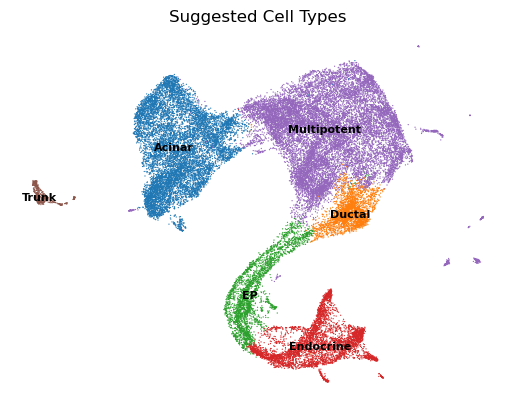

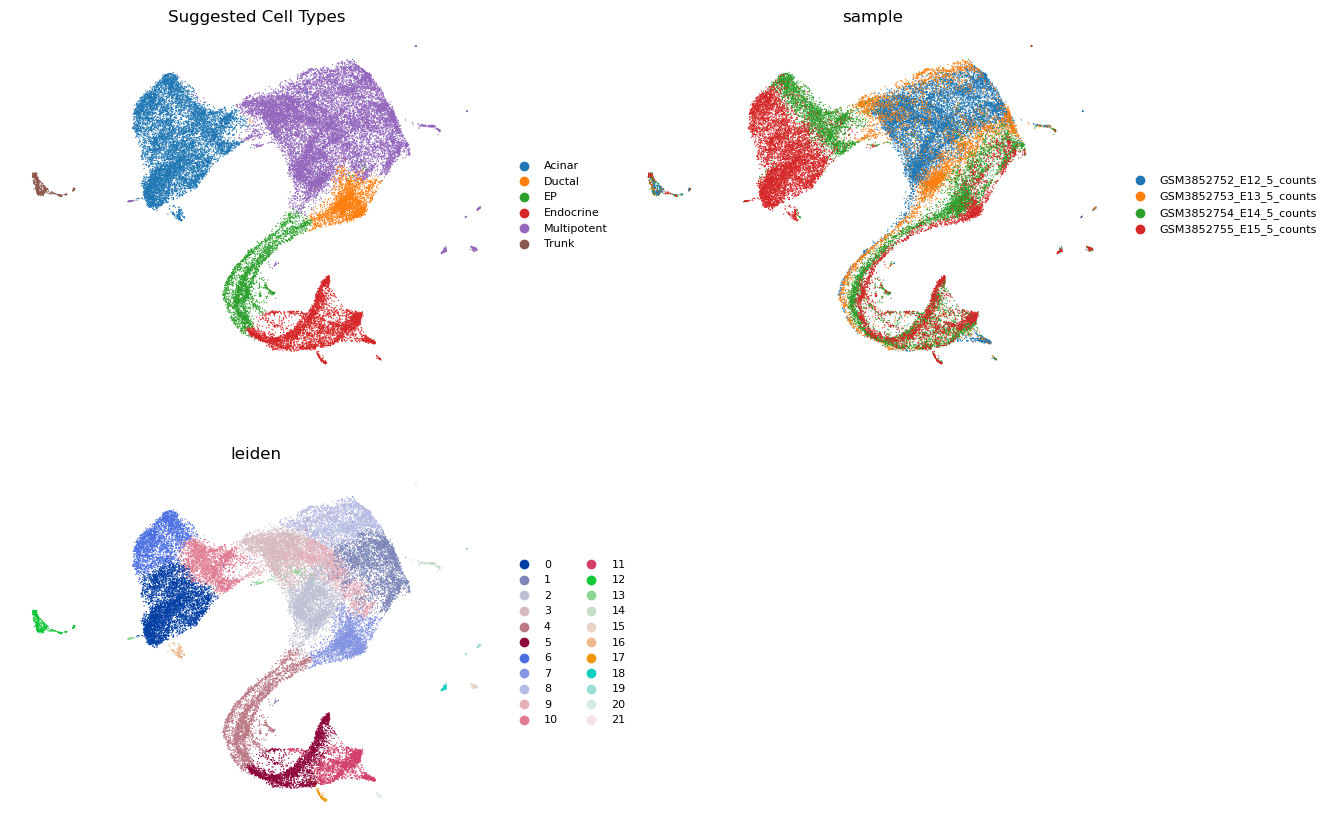

In [48]:


# Attach suggested labels for plotting
adata_proc.obs["celltype"] = adata_proc.obs[cluster_key].map(suggested)


sc.pl.umap(
    adata_proc,
    color=["celltype"],
    legend_loc="on data",
    legend_fontsize=8,
    frameon=False,
    title="Suggested Cell Types",
    ncols = 2
 
)

sc.pl.umap(
    adata_proc,
    color=["celltype","sample", cluster_key],
    #legend_loc="on data",
    legend_fontsize=8,
    frameon=False,
    title="Suggested Cell Types",
    ncols = 2
 
)